<a href="https://colab.research.google.com/github/GitDashHero/GitDashHero/blob/main/Product_Recommender4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRODUCT RECOMMENDER SYSTEM - CSDA 1040**

### **Context: Building a Product Recommender System**

Everyday millions of products get sold online. It has been established that products recommended to users based on popularity and other metrics on e-commerce websites leads to enhanced user experience. Most popular e-commerce website boost their average order value and also increases revenues significantly thereby improves conversion. Recommender systems are among the most visible and successful applications of Articial Intelligence and Machine Learning technology in practice. Nowadays, such systems accompany us
through our daily online lives — for example on e-commerce sites, on media streaming platforms, or in social networks. They help us by suggesting things that are assumed to be of interest to us and which we are correspondingly likely to inspect, consume, or purchase.

**Data Source: Source** - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.
Learning Outcomes

**BUSINESS PROBLEM:**

As a business that is invested in online sales, it has become imperative to build a product recommender system. Customers that are accustomed to online shopping have come to expect a level of personalization and recommendation to enhance their experience and might move away to websites that are more perceptive to their needs.

a) Helps User find the right type of product more easily which leads to better levels of engagement

b) Also helps the business use cross-sell, upsell and entice customers which leads to increased sales

c) Leads to a personalized experience 


**ANALYTICAL OBJECTIVE**

Build a Recommender Model that recommends products to users either based on popularity or ratings to increase customer engagement and drive sales. 

There are different types of recommender models based on popularity, user based, content based recommendation, collaborative filtering.



In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None



In [2]:
# Loading Data with headers and display
electronics_data = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId','Rating','timestamp'])
electronics_data = electronics_data.iloc[1:]
electronics_data.head()

,userId,productId,Rating,timestamp
1,A2CX7LUOHB2NDG,0321732944,5.0000000,1341100800.0000000
2,A2NWSAGRHCP8N5,0439886341,1.0000000,1367193600.0000000
3,A2WNBOD3WNDNKT,0439886341,3.0000000,1374451200.0000000
4,A1GI0U4ZRJA8WN,0439886341,1.0000000,1334707200.0000000
5,A1QGNMC6O1VW39,0511189877,5.0000000,1397433600.0000000


**DATA EXPLORATION**

In [3]:
# Datatypes

electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192096 entries, 1 to 3192096
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  float64
dtypes: float64(2), object(2)
memory usage: 97.4+ MB


In [4]:
# Shape of the data
electronics_data.shape

(3192096, 4)

In [5]:
# More on our data
electronics_data.describe()['Rating'].T

count   3192095.0000000
mean          3.9752777
std           1.4021868
min           1.0000000
25%           3.0000000
50%           5.0000000
75%           5.0000000
max           5.0000000
Name: Rating, dtype: float64

In [6]:
# Checking for any null or missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       1
timestamp    1
dtype: int64


In [7]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


**DATA DISTRIBUTION**

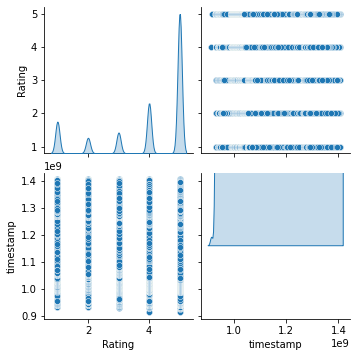

In [8]:

sns.pairplot(electronics_data, diag_kind= 'kde')


In [9]:
# Checking the distribution of the ratings
rating_counts = pd.DataFrame(electronics_data['Rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0000000,1733884
1,4.0000000,619460
2,1.0000000,391617
3,3.0000000,256319
4,2.0000000,190815


Text(0.5, 0, 'Rating Distribution')

Text(0, 0.5, 'Count')

([<matplotlib.patches.Wedge at 0x7f4960d51250>,
 [Text(-1.1727772471401794, 0.2541525695134766, '5.0'),
  Text(0.5578939074679748, -0.9480265755822012, '4.0'),
  Text(1.1988485727202942, -0.05255568177194563, '1.0'),
  Text(0.9116566810693687, 0.6155339924501193, '3.0'),
  Text(0.5625860855793836, 0.9452496476129819, '2.0')],
 [Text(-0.6841200608317713, 0.14825566554952802, '54.32%'),
  Text(0.3043057677098044, -0.5171054048630187, '19.41%'),
  Text(0.6993283340868381, -0.030657481033634953, '12.27%'),
  Text(0.49726728058329195, 0.3357458140637014, '8.03%'),
  Text(0.30686513758875467, 0.5155907168798083, '5.98%')])

(-1.2157865398449696,
 1.2150826205469787,
 -1.1149910052649246,
 1.1313380691203048)

Text(0.5, 1.0, 'Rating Ratio')

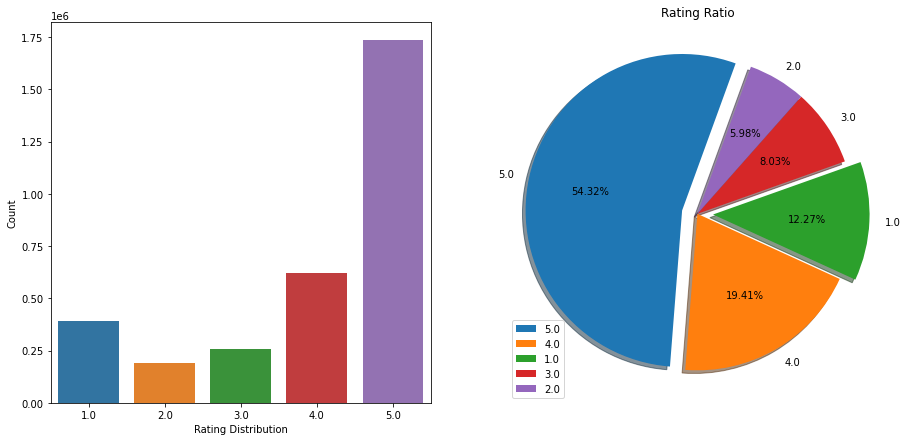

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(electronics_data['Rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

**OBSERVATIONS:**

We can see that most customers provide a rating of "5". Very few customers have given a rating of "2". 

From the barplot and pia chart we can clearly see that approx 55% of data have 5 rating followed by 4(approx 19%). Least number of people have given 2 rating. 

Either most products are liked by customers or there is more to investigate such as dropping of reviews by bots or promotional events. 

Are customers asked for feedback, if they give a lower rating thus making it easier to go with a rating of "5"?

**UNIQUE USERS AND NUMBER OF UNIQUE PRODUCTS**

In [11]:
electronics_data.productId = electronics_data.productId.fillna('')

In [12]:
print("\nTotal no of Ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of Products  :", len(np.unique(electronics_data.productId)))


Total no of Ratings : 3192096
Total No of Users   : 2029434
Total No of Products  : 173704


In [13]:
#Dropping the Timestamp Column and it is not needed for our analysis

electronics_data.drop(['timestamp'], axis=1,inplace=True)

**POPULARITY BASED RECOMMENDER**

Popularity based recommendation system uses the most frequently sold items to drive sales. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

This is good for new users when data is not available on their preferences.


In [14]:
#  Taking Subset of users who have given 50 or more number of ratings
users_counts = electronics_data['userId'].value_counts().rename('users_counts')
users_data   = electronics_data.merge(users_counts.to_frame(),
                                left_on='userId',
                                right_index=True)

In [15]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df.tail()

# Customers who have rated more than 50 products. These customers seem like they are regular buyers and provide regular feedback.

,userId,productId,Rating,users_counts
2897164,A2CIQEY05SPHTZ,B002VPDM2K,3.0000000,51
2902224,A2CIQEY05SPHTZ,B002VPE1Y8,4.0000000,51
2936096,A2CIQEY05SPHTZ,B002XUL5OU,4.0000000,51
2982519,A2CIQEY05SPHTZ,B0030M5NFC,4.0000000,51
3075349,A2CIQEY05SPHTZ,B0035MDZKM,4.0000000,51


**Resolving the "Grey Sheep" Problem:**

"Recommender Systems have been successfully applied to alleviate the information overload problem and assist the process of decision making. Collaborative filtering, as one of the most popular recommendation algorithms, has been fully explored and developed in the past two decades. However, one of the challenges in collaborative filtering, the problem of "Grey Sheep" user, is still under investigation. "Grey Sheep" users is a group of the users who have special tastes and they may neither agree nor disagree with the majority of the users. The identification of them becomes a challenge in collaborative filtering, since they may introduce difficulties to produce accurate collaborative recommendations" (Source:https://dl.acm.org/doi/abs/10.1145/3125649.3125651)

In [16]:
# We resolve the "Grey Sheep" Problem by taking a subset of products that have 10 or more ratings. 
# This will ensure that these are commonly purchased and rated.
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.tail()


,userId,productId,Rating,users_counts,product_rating_counts
208660,AHROSV6WJOEGY,B00006RVPW,5.0000000,50,10
208913,A3Q4TYJVAM4IRM,B00006RVPW,5.0000000,86,10
208786,A1CPRP3VFJRS1R,B00006RVPW,5.0000000,64,10
208259,A38KK0SZYEH5UD,B00006RVPW,5.0000000,92,10
209194,AI8EMB0HUC6Z5,B00006RVPW,5.0000000,62,10


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

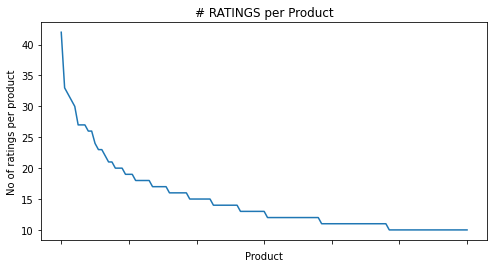

In [17]:
no_of_ratings_per_product = product_rating_data.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [18]:
#Average rating of the product 

product_rating_data.groupby('productId')['Rating'].mean().head()

productId
B00004SB92   4.3636364
B00004ZCJE   4.3000000
B00005LEN4   4.6956522
B00005T3G0   4.8181818
B00006B7DA   4.2500000
Name: Rating, dtype: float64

In [19]:
product_rating_data.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000BZL1P   5.0000000
B001TH7GUU   4.9473684
B00017LSPI   4.9333333
B0010Z28XG   4.9166667
B002WE6D44   4.9130435
Name: Rating, dtype: float64

In [20]:
#Top Products with maximum ratings of "5"

product_rating_data.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B002R5AM7C    42
B002SQK2F2    33
B000JMJWV2    32
B000N99BBC    31
B00004ZCJE    30
Name: Rating, dtype: int64

In [21]:
ratings_mean_count = pd.DataFrame(product_rating_data.groupby('productId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(product_rating_data.groupby('productId')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
productId,,
B00004SB92,4.3636364,11
B00004ZCJE,4.3000000,30
B00005LEN4,4.6956522,23
B00005T3G0,4.8181818,11
B00006B7DA,4.2500000,12


<Figure size 576x432 with 0 Axes>

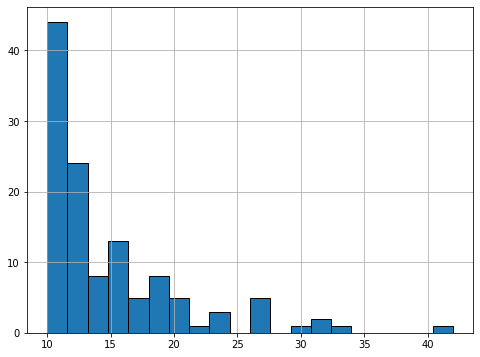

In [22]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=20)

**OBSERVATION:**

We see that the most customers have reviewed the top 25 products. This leads us to the conclusion that this seems to be the most popular product.

<Figure size 576x432 with 0 Axes>

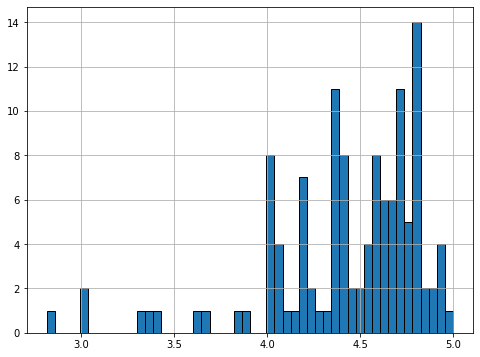

In [23]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

**OBSERVATION**

Here we see that the items with most ratings seem to be popular and consistently score between Rating "4" to Rating "5"

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

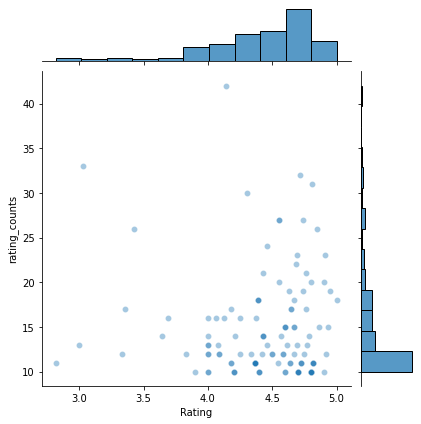

In [24]:
# Lets see the data on a jointplot
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

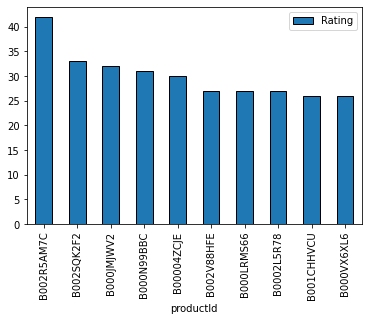

In [25]:
popular_products = pd.DataFrame(product_rating_data.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10).plot(kind = "bar")

The above chart shows us the Top 10 Recommended Products based on popularity

**DATA PREPARATION**



In [26]:
df1=product_rating_data.copy()
df2 = df1.drop(['users_counts', 'product_rating_counts'], axis=1)

In [27]:
df2.head()

,userId,productId,Rating
227983,A17HMM1M7T9PJ1,B00007GQLU,5.0000000
227685,A1VHCO8RQFIGQJ,B00007GQLU,5.0000000
227907,A3OA4DV4L81N1D,B00007GQLU,5.0000000
227909,AAQ9NJ480N9W5,B00007GQLU,4.0000000
227578,A4WEZJOIZIV4U,B00007GQLU,5.0000000


In [28]:
!pip3 install numpy
!pip3 install scikit-surprise

In [29]:
from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

import time

In [30]:
# Spliting the data randomly into train and test dataset. (Split it in 70/30 ratio)

k = 5 
#(To Get top - K ( K = 5) recommendations)
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(df2[['userId', 'productId', 'Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

**DATA MODELING**

Here we will try two types of Popularity Recommender Models - 

1) Using Mean Product Rating

2) Using Ranking Based Rating

In [31]:
# 1) Using Mean Product Rating
df2.groupby('productId')['Rating'].mean().head()

productId
B00004SB92   4.3636364
B00004ZCJE   4.3000000
B00005LEN4   4.6956522
B00005T3G0   4.8181818
B00006B7DA   4.2500000
Name: Rating, dtype: float64

In [32]:
df2.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000BZL1P   5.0000000
B001TH7GUU   4.9473684
B00017LSPI   4.9333333
B0010Z28XG   4.9166667
B002WE6D44   4.9130435
Name: Rating, dtype: float64

In [33]:
prod_rating_count = pd.DataFrame(df2.groupby('productId')['Rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(df2.groupby('productId')['Rating'].count())
prod_rating_count.head(k)

,Rating,prod_rating_count
productId,,
B0000BZL1P,5.0000000,18
B001TH7GUU,4.9473684,19
B00017LSPI,4.9333333,15
B0010Z28XG,4.9166667,12
B002WE6D44,4.9130435,23


In [34]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,Rating,prod_rating_count
productId,,
B002R5AM7C,4.1428571,42
B002SQK2F2,3.0303030,33
B000JMJWV2,4.7187500,32
B000N99BBC,4.8064516,31
B00004ZCJE,4.3000000,30


These are the TOP 5 popular products that would be recommended based on Mean Product Rating

2) Ranking Based Rating

In [35]:
df2_grouped = df2.groupby('productId').agg({'userId': 'count'}).reset_index()
df2_grouped.rename(columns = {'userId': 'Score'},inplace=True)
df2_grouped.head()

,productId,Score
0,B00004SB92,11
1,B00004ZCJE,30
2,B00005LEN4,23
3,B00005T3G0,11
4,B00006B7DA,12


In [36]:
#Sort the products on recommendation score 
df2_sort = df2_grouped.sort_values(['Score', 'productId'], ascending = [0,1]) 
      
#Generate a product rank based upon score 
df2_sort['Rank'] = df2_sort['Score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = df2_sort.head(k) 
popularity_recommendations 

,productId,Score,Rank
106,B002R5AM7C,42,1.0000000
108,B002SQK2F2,33,2.0000000
37,B000JMJWV2,32,3.0000000
44,B000N99BBC,31,4.0000000
1,B00004ZCJE,30,5.0000000


**MODEL DEPLOYMENT AND EVALUATION**

In [37]:
# Using popularity based recommender model to make predictions and find recommendations for random list of users with inferences

import warnings
warnings.filterwarnings('ignore')
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [38]:
find_recom = [15,121,55,230,477]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

     userID   productId  Score      Rank
106      15  B002R5AM7C     42 1.0000000
108      15  B002SQK2F2     33 2.0000000
37       15  B000JMJWV2     32 3.0000000
44       15  B000N99BBC     31 4.0000000
1        15  B00004ZCJE     30 5.0000000


Here is the recommendation for the userId: 121

     userID   productId  Score      Rank
106     121  B002R5AM7C     42 1.0000000
108     121  B002SQK2F2     33 2.0000000
37      121  B000JMJWV2     32 3.0000000
44      121  B000N99BBC     31 4.0000000
1       121  B00004ZCJE     30 5.0000000


Here is the recommendation for the userId: 55

     userID   productId  Score      Rank
106      55  B002R5AM7C     42 1.0000000
108      55  B002SQK2F2     33 2.0000000
37       55  B000JMJWV2     32 3.0000000
44       55  B000N99BBC     31 4.0000000
1        55  B00004ZCJE     30 5.0000000


Here is the recommendation for the userId: 230

     userID   productId  Score      Rank
106     230  B002R5AM7C  

In [39]:
import pickle
pickle.dump(popularity_recommendations ,open('mostpopular.pkl','wb'))

**NOTE:**

Since this is a popularity-based recommender model, recommendations remain the same for all users. We predict the products based on the popularity. It is not personalized to the user.

**COLLABORATIVE FILTER MODELLING**

We will use the SVD and KNN based modeling to find the closest product to the chosen product and also closest User Profile to the current User Profile


**SVD**

In [40]:
# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8880  0.8120  0.9444  0.8320  0.8530  0.8659  0.0466  
MAE (testset)     0.6503  0.6178  0.6881  0.6065  0.6366  0.6399  0.0285  
Fit time          0.08    0.09    0.08    0.08    0.08    0.08    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.00    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8210


0.8210317091396195

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442


**Comment:** Here we can see that the RMSE of testset and complete dataset found from cross_validation is almost same and it seems like our model is performing well on trainset and testset.

**SVD++**

In [41]:
# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)


# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVD++', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'], 
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)
# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
cv_results

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8564  0.7631  0.9198  0.8776  0.8614  0.8557  0.0514  
MAE (testset)     0.6499  0.5738  0.6492  0.6288  0.6201  0.6244  0.0278  
Fit time          0.36    0.33    0.34    0.33    0.32    0.34    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8153


0.815331551649719

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244


**KNN BASIC**

In [42]:
knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])



0.9467501900351591
0.9637944723423129
0.9579017032577207
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 25, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [43]:
# Creating Model using best parameters
knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9566  0.9471  0.9921  1.0177  0.9630  0.9753  0.0260  
MAE (testset)     0.6566  0.6240  0.6778  0.6736  0.6502  0.6564  0.0192  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 1.0119


1.0119168692862568

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244
2,KNNBasic,0.9753044,0.6564173,0.0047192,0.0056342


**KNNWithZScore**

In [44]:
# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)
# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9449  0.8978  0.8856  1.0335  0.8812  0.9286  0.0571  
MAE (testset)     0.6543  0.5908  0.6149  0.6775  0.5935  0.6262  0.0343  
Fit time          0.01    0.02    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.9617


0.9617047967586995

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244
2,KNNBasic,0.9753044,0.6564173,0.0047192,0.0056342
3,KNNWithZScore,0.9286006,0.6261830,0.0129176,0.0074487


**KNNWithMeans User-User**

In [45]:
# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)
# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0126  0.9324  1.0148  1.0178  1.0739  1.0103  0.0452  
MAE (testset)     0.6529  0.6568  0.6698  0.7032  0.7176  0.6801  0.0258  
Fit time          0.02    0.02    0.01    0.01    0.01    0.02    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.9262


0.9262069504005537

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244
2,KNNBasic,0.9753044,0.6564173,0.0047192,0.0056342
3,KNNWithZScore,0.9286006,0.6261830,0.0129176,0.0074487
4,KNNWithMeans User-User,1.0102983,0.6800511,0.0154708,0.0098921


**KNNWithMeans Item-Item**

In [46]:
# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnMeansII_model.fit(trainset)

# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], 
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansII, verbose=True)
print("=====================================================================")
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0331  0.8957  0.9132  0.9131  0.9784  0.9467  0.0516  
MAE (testset)     0.7018  0.6131  0.6302  0.6248  0.6656  0.6471  0.0325  
Fit time          0.01    0.01    0.02    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.9053


0.9053276867702928

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244
2,KNNBasic,0.9753044,0.6564173,0.0047192,0.0056342
3,KNNWithZScore,0.9286006,0.6261830,0.0129176,0.0074487
4,KNNWithMeans User-User,1.0102983,0.6800511,0.0154708,0.0098921
5,KNNWithMeans Item-Item,0.9466832,0.6470933,0.0104959,0.0068626


**COMPARING ALL RMSE AND MAE ACROSS MODELS**

<Figure size 1440x1080 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Algorithms on RMSE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'RMSE Value')

Text(0.5, 1.0, 'Comparison of Algorithms on MAE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'MAE Value')

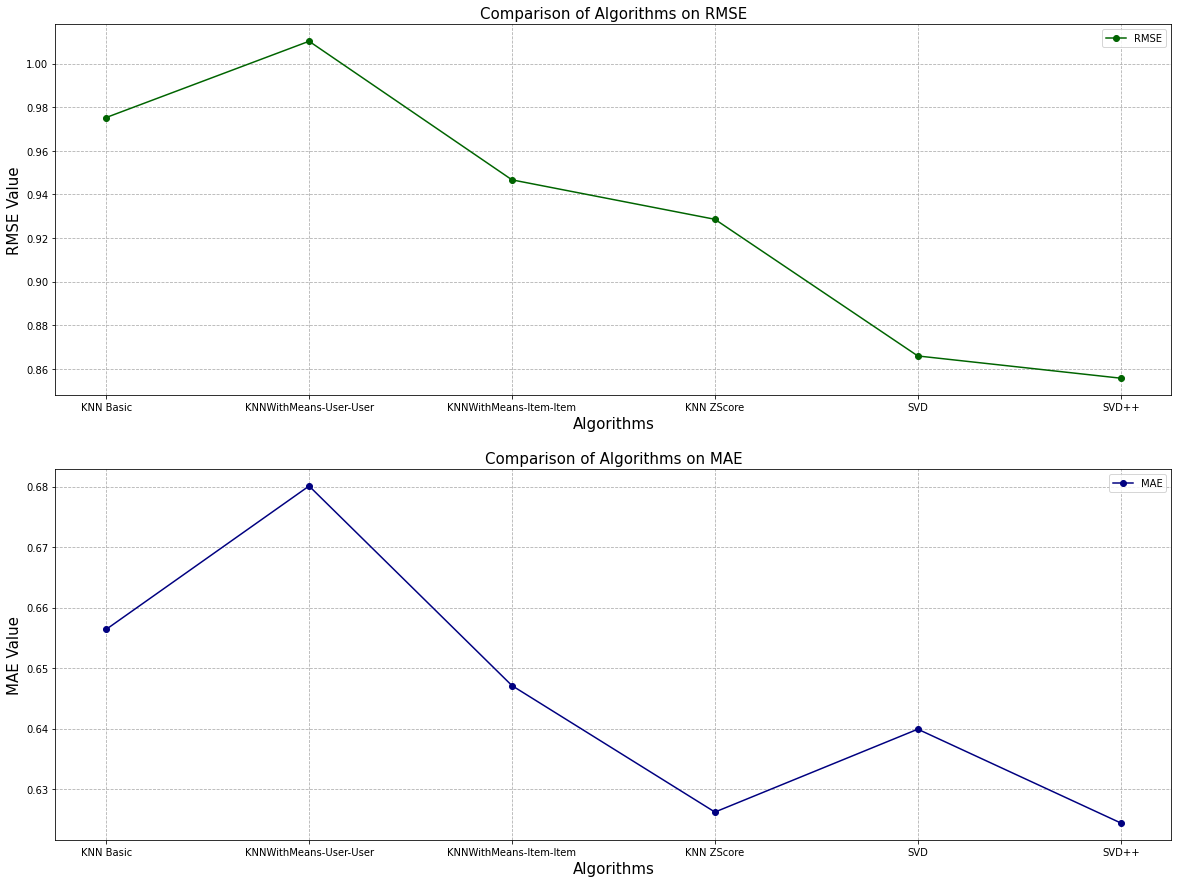

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.8658590,0.6398626,0.0800443,0.0040442
1,SVD++,0.8556603,0.6243647,0.3361405,0.0074244
2,KNNBasic,0.9753044,0.6564173,0.0047192,0.0056342
3,KNNWithZScore,0.9286006,0.6261830,0.0129176,0.0074487
4,KNNWithMeans User-User,1.0102983,0.6800511,0.0154708,0.0098921
5,KNNWithMeans Item-Item,0.9466832,0.6470933,0.0104959,0.0068626


In [47]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD', 'SVD++']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv, svdpp_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

cv_results


**MODEL EVALUATION:**

From above algorithm comparisons plots we can infer the followings:

1.   RMSE : we can see that SVD++ is giving the best RMSE values
2.   MAE : Here SVD++ and KNNWithMean-User-User both are giving the best MAE value
3.   SVD++ is showing the best RMSE in Matrix Factorization Based Algorithms.
4.   KNNWithMeans is giving the best RMSE in Collaborative Filtering Algorithms.
5.  If compare SVD and SVD++ then can notice that RMSE and MAE value of SVD is slightly differs from the SVD++ but the Fit Time and Test Time taken by SVD is significant less(12 times) than SVD++. So, we will proceed with SVD got get top-k recommendations


**MODEL DEPLOYMENT**

In [48]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'A100WO06OQR8BQ': [('B000VX6XL6', 4.740748179429496),
              ('B00006RVPW', 4.3698477598492325)],
             'A10Y058K7B96C6': [('B001GS8FZ2', 4.078371420929864),
              ('B001CHHVCU', 3.7776546920448206)],
             'A11KZ906QD08C5': [('B002WE6D44', 4.878942785598418),
              ('B00006I53S', 4.536199253633474),
              ('B000L47AHG', 4.414027919323077)],
             'A12DQZKRKTNF5E': [('B002WE6D44', 4.9402014758810395),
              ('B0002L5R78', 4.604922019133591),
              ('B001E1Y5O6', 4.545799686061484)],
             'A141OPVE376YFI': [('B002WE6D44', 4.801816050392606),
              ('B000U5TUWE', 4.370027805628252),
              ('B000TG4BA0', 4.2152184938739685)],
             'A1435P5AMCPB3X': [('B000M17AVO', 4.496005343752952)],
             'A149RNR5RH19YY': [('B001F51G16', 4.620718561872584),
              ('B00007KDVI', 3.8548080508883302)],
             'A14JBDSWKPKTZA': [('B001TH7GVE', 4.95128621981

**NOTE:**

The above list shows the model recommendations the "TOP 5" products for each user. There are some cases in which less than 5 products are recommended as the model is not able to find the appropriate number of neighbors

In [49]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print('Precision : ', sum(prec for prec in precisions.values()) / len(precisions))
    print('Recalls : ',sum(rec for rec in recalls.values()) / len(recalls))


Precision :  0.8697916666666669
Recalls :  0.9758522727272727


Precision :  0.8741441441441442
Recalls :  0.9873873873873875


Precision :  0.8714539007092199
Recalls :  0.9960106382978723


Precision :  0.9042328042328042
Recalls :  0.9905517762660621


Precision :  0.8766098484848485
Recalls :  0.987689393939394


In [50]:
pickle.dump(svd_model,open('mostrelevant.pkl','wb'))

**Comment:** Precision and Recall have been calculated at k=5. 

 Precision and Recall are binary metrics used to evaluate models with binary output. We need a way to translate our numerical problem (ratings usually from 1 to 5) into a binary problem (relevant and not relevant items). To do the translation we assume that any true rating above 3.5 corresponds to a relevant item and any true rating below 3.5 is irrelevant.

Precision at 5 within the TOP 5 recommendations is alomost 85%. This means that 86% of the recommendation are relevent to the users.
Recall at 5 within the TOP 5 recommendations problem is almost 95%. This means that 95% of the total number of the relevent products appear in the top-k result.

**CONCLUSION**

- EDA shows us that most of the customers give a rating of "5". This leads us to the conclusion that customers are very satisfied with their purchase. It may need some investigation to see if some bots or mandatory feedback at lower ratings are causing the majority to give a top rating of "5"

- Subset of users who have provided 50 or more ratings and products which have received more than 10 ratings have been used to remove outliers and overcome Grey Sheep issue.

- Popularity Model - shows the TOP 5 recommended products irrespective of the user. The same 5 product will be recommended for every user.

- 'Matrix Factorization Based Algorithms' & 'k-NN Based Algorithms' were used to build Collaborative Filtering model.

- SVD++ yields the lowest RMSE which is slightly better than SVD but computational time of SVD++ is 12 times greater than SVD. SVD can be used to get the recommended products.

- Precision which is almost 86%. which can be interpreted as 86% of the recommendations are actually relevant to the user.

- Recall is at 96% which can be interpreted as percent of the relevant items were recommended in the top-k items.

In [51]:
!pip install colabcode
!pip install fastapi

In [52]:
import uvicorn

In [53]:
from pydantic import BaseModel

In [54]:
from colabcode import ColabCode

In [55]:
from fastapi import FastAPI

In [56]:
from typing import Optional

In [57]:
#cc = ColabCode(port=12000, password=None, authtoken=None, mount_drive=False, code=False, lab=False)
cc = ColabCode(port=12000, code=False)

In [58]:
app = FastAPI()

@app.get("/")
async def read_root():
  return {"PRODUCT RECOMMENDER":"APP2"}

In [59]:
app.main:app

In [ ]:
cc.run_app(app=app)

In [60]:
%%writefile models.py
from pydantic import BaseModel, conlist
from typing import List

class electronics_data(BaseModel)
data: List[conlist(float, min_items=1, max_items=1)]

Public URL: NgrokTunnel: "https://9b44-35-221-36-166.ngrok.io" -> "http://localhost:12000"
Overwriting models.py


In [61]:
import pickle
import logging
from fastapi import FastAPI

In [62]:
pickle.dump(svd_model,open('mostrelevant.pkl','wb'))

In [63]:
%%writefile models.py
from pydantic import BaseModel, conlist
from typing import List

class electronics_data(BaseModel):
  userId: object 
  productId: object 
  Rating: float64
  timestamp: float64
data: List[conlist(float, min_items=1, max_items=1)]

Overwriting models.py


In [64]:
import pickle
import logging


In [65]:
# Create a pickle file
pickle_out = open ("mostpopular.pkl", "wb")
pickle.dump(most_popular, pickle_out)
pickle_out.close()

In [66]:
# Create the app object
app = FastAPI()
pickle_in = open ("mostpopular.pkl", "rb")
most_popular=pickle.load(pickle_in)


In [67]:
# Index route, open automatically on http://127.0.0.1:8000
@app.get('/')
def index():
  return{'message': 'My First Public App'}

In [68]:
# Route with a single param 
@app.get('/Product Recommender')
def get_name(Product Recommender: str):
  return {'message': f'First, {Product Recommender}'}

SyntaxError: ignored

INFO:     Started server process [5207]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)


In [ ]:
# Expose the prediction
@app.post('/predict')
top_n = defaultdict(list)

In [ ]:

@app.get('/top_n')
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n
return {'prediction': top_n}

In [ ]:
%%writefile models.py
from pydantic import BaseModel, conlist
from typing import List

class electronics_data(BaseModel):
  userId: object 
  productId: object 
  Rating: float64
  timestamp: float64
data: List[conlist(float, min_items=1, max_items=1)]

In [ ]:
from fastapi import FastAPI

app = FastAPI(title="Model Deployment", description="with FastAPI and Colab", version="1.0")

In [ ]:
##Initialize logging
#my_logger = logging.getLogger()
#my_logger.setLevel(logging.DEBUG)
#logging.basicConfig(level=logging.DEBUG, filename='logs.log')

In [69]:
model="/content/mostrelevant.pkl"
@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("mostrelevant.pkl", "rb")

@app.get('/')
def index():
  return {'message': 'Electronic Products Recommender App'}

@app.post('/predict')
async def get_predictions 
data= dict(popularity_recommendations)['data']:
        print(data)
        prediction = list(map(lambda x: popularity_recommendations_types[x], model.predict(data).tolist()))
        log_proba = model.predict_log_proba(data).tolist()
        return {"prediction": prediction, "log_proba": log_proba}

    except:
        my_logger.error("Something went wrong!")
        return {"prediction": "error"}

SyntaxError: ignored

In [ ]:
#server = ColabCode(port=10000, code=False)

In [ ]:
#server.run_app(app=app)

In [ ]:
!pip install colabcode
!pip install fastapi

In [ ]:
from colabcode import ColabCode
from fastapi import FastAPI

In [ ]:
cc = ColabCode(port=12000, code=False)

In [ ]:
app = FastAPI()

@app.get("/") # no end point, just the root, a very light-weight app
async def read_root():
  return {"message": "My First Product Recommender"}

In [ ]:
cc.run_app(app=app)

In [ ]:
import pickle

In [ ]:
import pickle
import logging
from fastapi import FastAPI
from models import Iris

app = FastAPI(title="ML Models as API on Google Colab", description="with FastAPI and ColabCode", version="1.0")

# # Initialize logging
# my_logger = logging.getLogger()
# my_logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG, filename='logs.log')

model = None

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("model_gb.pkl", "rb"))

@app.post("/api", tags=["prediction"])
async def get_predictions(iris: Iris):
    try:
        data = dict(iris)['data']
        print(data)
        iris_types = {
            0: 'setosa',
            1: 'versicolor',
            2: 'virginica'
        }
        prediction = list(map(lambda x: iris_types[x], model.predict(data).tolist()))
        log_proba = model.predict_log_proba(data).tolist()
        return {"prediction": prediction, "log_proba": log_proba}
    except:
        my_logger.error("Something went wrong!")
        return {"prediction": "error"}

In [ ]:
cc.run_app(app=app)